# 2D Convolutional Neural Networks

In this lab, we will train a traditional VGG16 model (which is a [Keras application](https://keras.io/api/applications/)), where we will train the last couple of layers to adapt it to our problem.

The problem is to predict one of 6 categories of pictures, whether they are 'buildings', 'forest', 'glacier', 'mountain', 'sea' or 'street'. This problem comes from an Intel Image Classification challenge and is available [here](https://www.kaggle.com/puneet6060/intel-image-classification/version/2).

First, we load the data.

In [1]:
from IPython.display import Image

import numpy as np
import h5py as h5py # This is a Pythonic interface to the HDF5 binary data format
import PIL

# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [2]:
# Update gdown to latest version
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [7]:
# download datafile
!gdown -q 'https://drive.google.com/uc?id=1HEB7JHl6uSANiENvaHBxhzmkkZ9YlhEC'

In [8]:
# unzip datafile
!unzip -q IntelClassification.zip

Let's see a couple of examples.

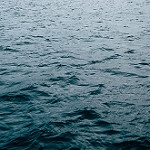

In [9]:
Image(filename='IntelClassification/seg_train/sea/17997.jpg') 

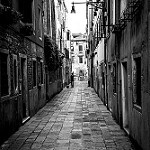

In [10]:
Image(filename='IntelClassification/seg_train/street/8294.jpg')

## VGG16

The VGG 16 model is a classic model in Deep Learning. It is a 16 layer model, following the structure that we discussed in the lectures.

This model was trained over the ImageNet data, thus looking to classify among 1000 different types of objects, over a very large database of images. We can leverage these already-trained weights, and  adapt just the last few layers for our purposes.

We start by loading the VGG16 model. Keras comes pre-packaged with a series of models, loaded into the [Applications library](https://keras.io/applications/). We start by first loading the model on-the-fly using the library. We can check the options of the model in the options of the function [VGG16](https://keras.io/api/applications/vgg/#vgg16-function).

We also need a package that allows for an efficient storage of the model using a binary format. The package is called [h5py](https://www.h5py.org/) and also allows for storing your pre-trained models. You can read a tutorial for this [here](https://machinelearningmastery.com/save-load-keras-deep-learning-models/).

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

model = VGG16(weights = 'imagenet',      # The weights from the ImageNet competition
              include_top = False,       # Do not include the top layer, which classifies
              input_shape= (224, 224, 3) # Input shape. Three channels, and BGR (NOT RGB!!!)
             )

58889256/58889256 [==============================] - 3s 0us/step


This will download the model and save it to our unoriginally named variable model. It is a pretty beefy download, at around 500MB. Luckly we have fast internet in Colab.

We can now check the details of the model as usual.

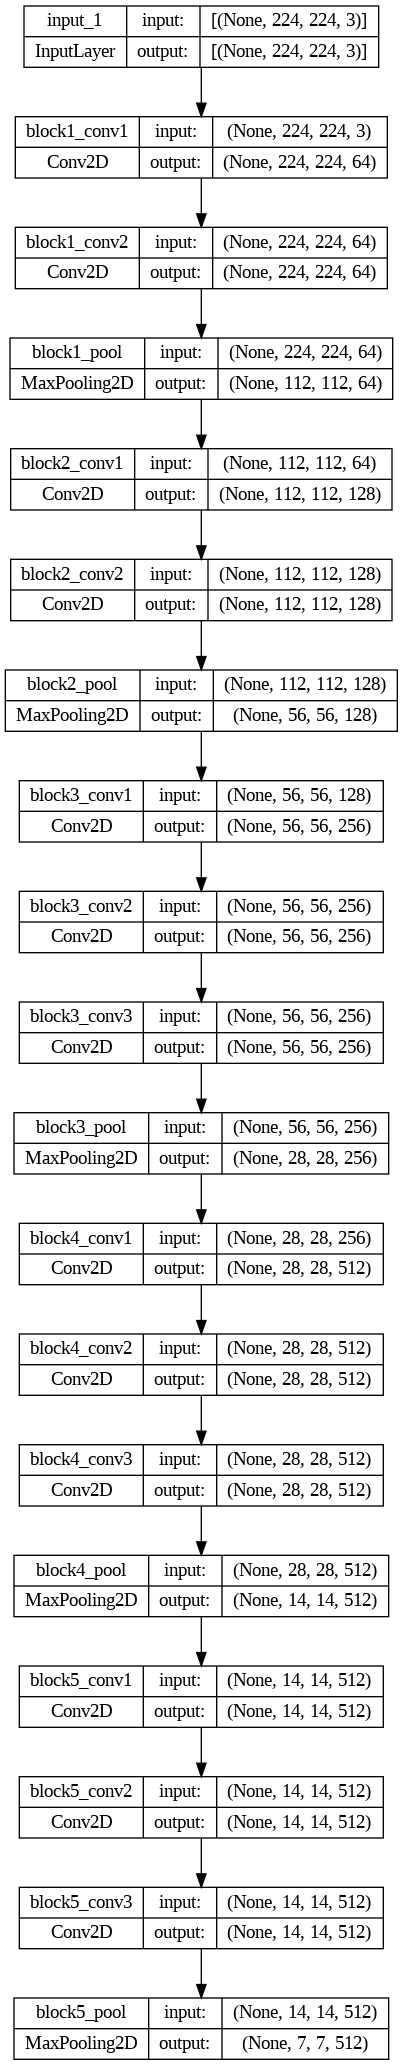

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

At this point, every single parameter is trainable. We don't need this, as we want to use the parameters that come with the model. We will create a parallel model to store the new trainable layers, and then set all of these layers as untrainable. We will finally add a Dense layer with 128 neurons, plus a Dense layer with two classes.

In [13]:
# Create new model
CBModel = Sequential()

# Copy the layers to our new model. This needs to be done as there is a bug in Keras.
for layer in model.layers:
    CBModel.add(layer)

# Set the layers as untrainable
for layer in CBModel.layers:
    layer.trainable = False

In [14]:
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [15]:
# Set layer as trainable.
CBModel.layers[15].trainable = True
CBModel.layers[16].trainable = True

In [16]:
# We now add the new layers for prediction.
CBModel.add(Flatten(input_shape=model.output_shape[1:]))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.5))
CBModel.add(Dense(64, activation = 'relu'))
CBModel.add(Dropout(0.5))
CBModel.add(Dense(6, activation = 'softmax'))

In [17]:
# How does the model look like?
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [18]:
# Compiling the model!
import tensorflow.keras as keras

CBModel.compile(loss = 'categorical_crossentropy', # This is NOT a binary problem!
                optimizer = optimizers.SGD(learning_rate=0.001),
                metrics = [ keras.metrics.CategoricalCrossentropy(), keras.metrics.Accuracy() ]
               )

Ready! We can now load the data. We have our set of pictures ready for this example. For this problem we will use a generator. A generator takes images from a directory, and feeds them to the model as needed. **This is necessary to work with big data**. We cannot expect the datasets we work here to fit in memory, so we take the images as needed.

We will first build two image generators (one for testing and one for training), which will generate new samples on the fly using our pictures as input.

We will also conduct **data augmentation**, which are a series of mathematical operations over the datasets to make them search more complex patterns. If you use augmentation, learning will take longer but be more robust. The process to work with this data is the following:

1. Create an [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) object which will process the images and load them as needed.

2. Call the ```flow_from_directory``` from our generator which will split the data into two parts, one for training and one for validation.

In [19]:
# prepare data augmentation configuration. One for train, one for test.
train_datagen = ImageDataGenerator(
                                  rescale=1./255,                           # NNets like small inputs. Rescale.
                                  shear_range=0.2,                          # Shear?
                                  zoom_range=0.2,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=True,                     # Flip horizontally?
                                  vertical_flip=False,                      # Flip vertically?
                                  preprocessing_function=preprocess_input,  # VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0.2                    # Create a validation cut?
                                  )

test_datagen = ImageDataGenerator(
                                  rescale=1./255,                         # NNets like small inputs. Rescale.
                                  shear_range=0,                          # Shear?
                                  zoom_range=0,                           # Zoom? 0.2 means from 80% to 120%
                                  horizontal_flip=False,                  # Flip horizontally?
                                  vertical_flip=False,                    # Flip vertically?
                                  preprocessing_function=preprocess_input,# VGG expects specific input. Set it up with this function that comes prepackaged.
                                  validation_split = 0                    # No validation cut for test.
                                  )


# We will use a batch size of 64. Depends on RAM of GPU.
batch_size = 64

# Train data generator. We point to the training directory!
train_data_dir = 'IntelClassification/seg_train'

# VGG requires 224 x 224 images.
(img_height, img_width) = (224, 224)

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='categorical',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'training',                 # What subset to use?
                                                    shuffle = True                       # Shuffle the data?
                                                    )

validation_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,                      # Where are the pics
                                                    target_size=(img_height, img_width), # What size should they be
                                                    batch_size=batch_size,               # Size of batch
                                                    class_mode='categorical',            # Class mode, whether 'binary' or 'categorical'
                                                    subset = 'validation',               # What subset to use?
                                                    shuffle = True                       # Shuffle the data?
                                                    )

# Test data generator.
test_data_dir = 'IntelClassification/seg_test'
test_generator = test_datagen.flow_from_directory(
                                                  test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=1, # Pass images one-by-one
                                                  class_mode='categorical',
                                                  shuffle = False # Test set does NOT shuffle the data.
                                                  )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Now the system is ready to train from the images that we have loaded. We now feed the generators to the model, and ask to train for a certain number of epochs. We found the following datasets:

- Train: 11,230 images belonging to 6 classes.
- Validation: Found 2804 images belonging to 6 classes.
- Test: 3000 images belonging to 6 classes.

In [20]:
# Number of epochs
epochs = 3

# Train!
CBModel.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            steps_per_epoch = 32, # Usually cases / batch_size = 176. Reduced to 32 so it runs faster.
            validation_steps = 22 # Number of validation steps. Again cases / batch_size = 44.
          )

Epoch 1/3
32/32 [==============================] - 65s 1s/step - loss: 1.7945 - categorical_crossentropy: 1.7945 - accuracy: 0.0000e+00 - val_loss: 1.7188 - val_categorical_crossentropy: 1.7188 - val_accuracy: 0.0000e+00
Epoch 2/3
32/32 [==============================] - 46s 1s/step - loss: 1.7387 - categorical_crossentropy: 1.7387 - accuracy: 0.0000e+00 - val_loss: 1.6729 - val_categorical_crossentropy: 1.6729 - val_accuracy: 0.0000e+00
Epoch 3/3
32/32 [==============================] - 44s 1s/step - loss: 1.6966 - categorical_crossentropy: 1.6966 - accuracy: 0.0000e+00 - val_loss: 1.6280 - val_categorical_crossentropy: 1.6280 - val_accuracy: 0.0000e+00


The model is able to learn quite well! Let's check the convergence plot.

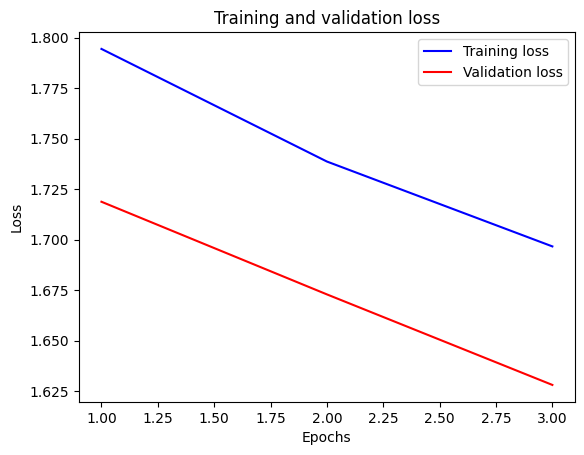

In [21]:
loss = CBModel.history.history['loss']
val_loss = CBModel.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the model still has much more to learn! Keep training until you get convergence.

Now, let's apply it to the test set and get a confusion matrix.

In [22]:
# Applying to the test set with a generator.
test_generator.reset()

# Get probabilities
output = CBModel.predict(test_generator)

3000/3000 [==============================] - 29s 9ms/step


In [23]:
output

array([[0.18231325, 0.18363814, 0.09187349, 0.15660045, 0.11507051,
        0.2705042 ],
       [0.19514443, 0.17771147, 0.1376474 , 0.1332329 , 0.11610904,
        0.24015471],
       [0.20858064, 0.19197324, 0.14495583, 0.13055725, 0.12143646,
        0.20249663],
       ...,
       [0.14983493, 0.17691472, 0.1962661 , 0.17113782, 0.15159008,
        0.15425633],
       [0.20579466, 0.16262743, 0.11694129, 0.1511671 , 0.07525326,
        0.2882163 ],
       [0.20165244, 0.18277016, 0.15212315, 0.118099  , 0.09923919,
        0.24611612]], dtype=float32)

In [24]:
# Calculate classes
pred_classes = np.argmax(output, axis=1)

labels = test_generator.classes

In [25]:
pred_classes

array([5, 5, 0, ..., 2, 5, 5])

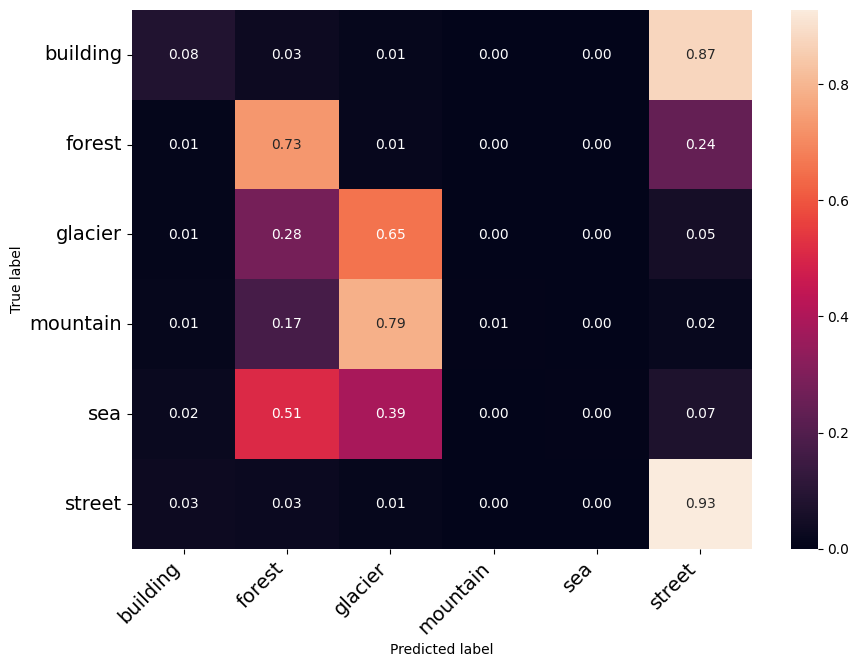

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline

# Calculate confusion matrix
confusion_matrix_net = confusion_matrix(y_true = labels, y_pred = pred_classes)

# Turn matrix to percentages
confusion_matrix_net = confusion_matrix_net.astype('float') / confusion_matrix_net.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_net, 
        index=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
        columns=['building', 'forest', 'glacier', 'mountain', 'sea', 'street'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot
plt.show()

Now that we are happy, we can save the model.

In [28]:
# Saving the model
CBModel.save('/content/VGG16_FM9528A.h5')

# and this is how to load the saved model
# CBModel = keras.models.load_model('/content/drive/MyDrive/VGG16_FM9528A.h5')

## Visualizing learning

As a final example. We will visualize the learning, to detect exactly what is happening.

We will use [Grad CAM](https://arxiv.org/abs/1610.02391), a method that allows visualizing how one image activates the neural network. Basically we will look for the direction that the model used to get to its decisions. This requires to do some iterations that we won't explain in detail. Please refer to chapter 5.4 of Chollet's book to check the details.

In [29]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [30]:
# Get the image in the right size
def get_img_array(img_path, size = (224, 224)):
    import tensorflow as tf
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array


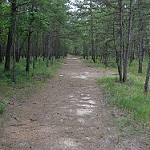

In [31]:
# Get an image
img_path = 'IntelClassification/seg_test/forest/20056.jpg'
data = get_img_array(img_path)

# Plot it
display(Image(img_path))

In [32]:
# The explainer. Gotten from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    from tensorflow import keras
    import tensorflow as tf
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [33]:
# Print the predictions
preds = CBModel.predict(preprocess_input(data/255))
print(preds)

1/1 [==============================] - 0s 154ms/step
[[0.02535962 0.03844077 0.00711656 0.8809224  0.01917978 0.02898085]]


This example shows the model is 99% sure this is a street. Now we need to configure our model. We neeed to get the layers that are used for prediction (i.e. everything after the last convolution) and the last convolutional layer.

Get them with a model.summary()

In [34]:
CBModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [35]:
# Set the layers
last_conv_layer_name = "block5_conv3"

classifier_layer_names =  ["block5_pool", 
                           "flatten",
                           "dense",
                           "dense_1",
                           "dense_2",]


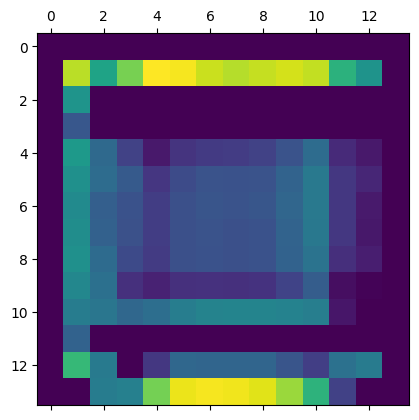

In [36]:
# Plot the heatmap!
heatmap = make_gradcam_heatmap(
    preprocess_input(data/255), CBModel, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Now, to really visualize what's going on, we will superimpose the heatmap over the input. The following code does just that.

<ipython-input-37-df90e1397958>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


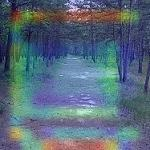

In [37]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "Street_Example.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))


Now we can clearly see what is happening. 

This is the importance of the modelling procedures: We need to understand how much diversity we are including in our images: If we don't we might end up learning other things!

Try to change the filters and learning other characteristics.